# Predicting Income from Census Data

## I. Task

In this workbook we will be modeling incomes from the 1994 US census in order to predict whether an individual earns more than $50,000 a year. We will do this by first cleaning the data, identifying significant factors, making necessary transformations, and finally performing three different classification methods.

In [107]:
#libraries I'll be using
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import patsy
import sklearn
from sklearn import linear_model
from sklearn import neighbors
from sklearn import tree
from sklearn import metrics
from sklearn import svm

## II. Dataset

The dataset I am using was downloaded from the UCI Machine Learning Repository at https://archive.ics.uci.edu/ml/datasets/Census+Income. It is a csv file listing the data of 32,561 individuals across 15 fields. Here are the features as displayed on the webpage:

<b>age</b>: continuous.

<b>workclass</b>: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.

<b>fnlwgt</b>: continuous.

<b>education</b>: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

<b>education-num</b>: continuous.

<b>marital-status</b>: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

<b>occupation</b>: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

<b>relationship</b>: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

<b>race</b>: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

<b>sex</b>: Female, Male.

<b>capital-gain</b>: continuous.

<b>capital-loss</b>: continuous.

<b>hours-per-week</b>: continuous.

<b>native-country</b>: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [108]:
df = pd.read_csv("adult.data")
print("Number of Entries:", df.shape[0])
df.head(3)

Number of Entries: 32561


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,fiftyk
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0


### Cleaning the Data

There were a few things I modified before reading the file into a Pandas dataframe. First, the original csv file did not contain names for the column fields, so I manually added them based on the names provided on the website. Second, the 'fiftyk' field contained strings '<=50k' and '>50k' which I converted to the values 0 and 1, repsectively. Third, the values included spaces after the commas so I went through and deleted them to make it easier for Pandas to parse. I made all of these adjustments in a text editor.

Unknown values are designated by a question mark, '?', so we will replace them with NaN and drop them all as there are only about 25 hundred.

In [109]:
df = df.replace('?',np.nan)
df = df.dropna()
df.shape

(30162, 15)

Now we will rename the columns, taking out the '-' characters. This will make it easier to use patsy later for building a model. I'll also convert some of the categorical variables we'll use later to integer values.

In [113]:
df = df.rename(columns={"education-num": "educationnum","marital-status":"maritalstatus",\
                        "hours-per-week": "hoursperweek",\
                       "capital-gain":"capitalgain","capital-loss":"capitalloss",\
                       "native-country":"nativecountry"})

df['maritalstatus'] = df['maritalstatus'].map({'Married-spouse-absent': 0, 'Widowed': 1, 'Married-civ-spouse': 2, \
                                                 'Separated': 3, 'Divorced': 4, \
                                                 'Never-married': 5, 'Married-AF-spouse': 6}).astype(int)

df['sex'] = df['sex'].map({'Male':0,'Female':1}).astype(int)

## III. Preliminary Observations

First we will look at the percentage of those who make more and less than 50k per year according to the data.

In [114]:
less = df[df['fiftyk'] == 0].shape[0]
more = df[df['fiftyk'] == 1].shape[0]
print("Number of people who make <=50k: ", less, "or ,", np.round(less / df['fiftyk'].size, 4)*100, "percent")
print("Number of people who make >50k: ", more, "or ,", np.round(more / df['fiftyk'].size, 4)*100, "percent")

Number of people who make <=50k:  22654 or , 75.11 percent
Number of people who make >50k:  7508 or , 24.89 percent


### Finding the most Predictive Variables

We will start by looking at a heatmap of correlations

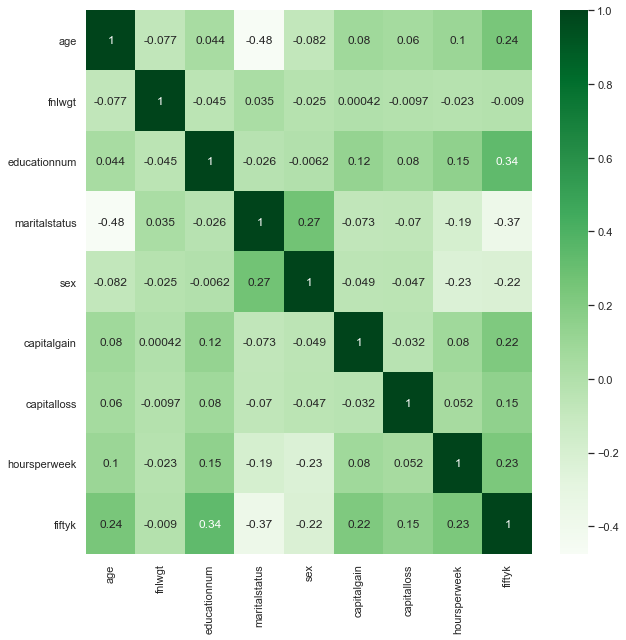

In [115]:
heat = df.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(heat,annot=True,cmap='Greens')
plt.show()

Looking at the plot we can see the factors most correlated with earning fiftyk are education and marital status. Age, Sex, hours per week, and capital gain also appear to be correlated to a lesser degree.

Let's plot some of those fields to see how they are distributed.

### Education

As we expected, higher education looks to be strongly correlated with earnings above 50k.

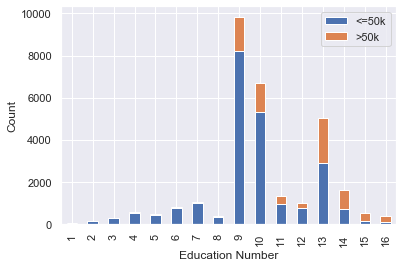

In [116]:
df.groupby(['fiftyk', df['educationnum']]).size().unstack(0).plot.bar(stacked=True)
L=plt.legend()
L.get_texts()[0].set_text('<=50k')
L.get_texts()[1].set_text('>50k')
plt.xlabel('Education Number')
plt.ylabel('Count')
plt.show()

### Marital Status

Being Married and living with your spouse is clear predictor of earnings above 50k

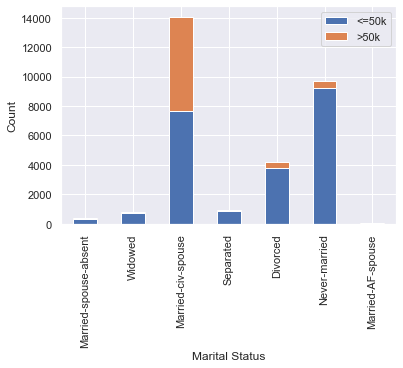

In [117]:
df.groupby(['fiftyk', df['maritalstatus']]).size().unstack(0).plot.bar(stacked=True)
L=plt.legend()
L.get_texts()[0].set_text('<=50k')
L.get_texts()[1].set_text('>50k')
plt.xticks([0,1,2,3,4,5,6],['Married-spouse-absent', 'Widowed', 'Married-civ-spouse', \
                            'Separated', 'Divorced', 'Never-married', 'Married-AF-spouse'])
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.show()

### Age

Earnings by age look pretty normally distributed. It seems that those aged 30-60 have a higher likelihood of earning more than 50k. This is likely a good predictor.

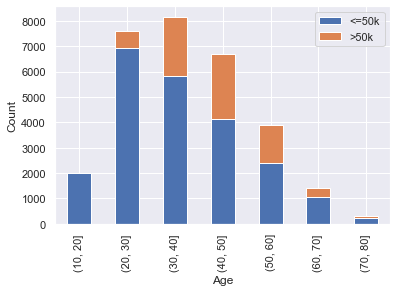

In [118]:
df.groupby(['fiftyk', pd.cut(df['age'], np.arange(10,90,10))]).size().unstack(0).plot.bar(stacked=True)
L=plt.legend()
L.get_texts()[0].set_text('<=50k')
L.get_texts()[1].set_text('>50k')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### Sex

It's hard to say that being male is a predictor since the number of males is more than double the number of females in the data, but perhaps we can try incoporating it in our model and see if our accuracy improves.

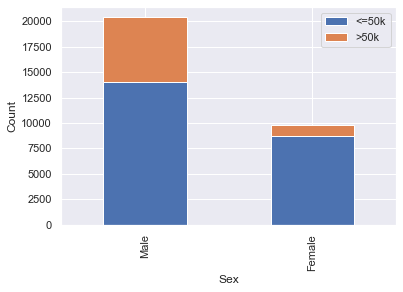

In [119]:
df.groupby(['fiftyk', df['sex']]).size().unstack(0).plot.bar(stacked=True)
L=plt.legend()
L.get_texts()[0].set_text('<=50k')
L.get_texts()[1].set_text('>50k')
plt.xticks([0,1],['Male','Female'])
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

### Hours per week

Looks like a big difference between those that work less than 40 and those that work more. I think this might be a good indicator for earnings.

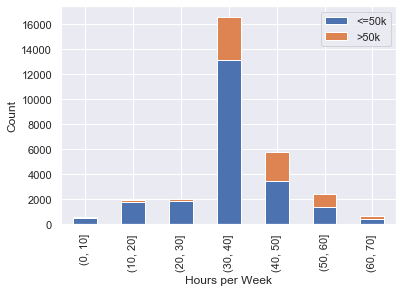

In [120]:
df.groupby(['fiftyk', pd.cut(df['hoursperweek'], np.arange(0,80,10))]).size().unstack(0).plot.bar(stacked=True)
L=plt.legend()
L.get_texts()[0].set_text('<=50k')
L.get_texts()[1].set_text('>50k')
plt.xlabel('Hours per Week')
plt.ylabel('Count')
plt.show()

### Capital Gains

This one is kinda tricky because there are some seriously large outliers. 

Mean value:  1092.01 
Maximum value 99999


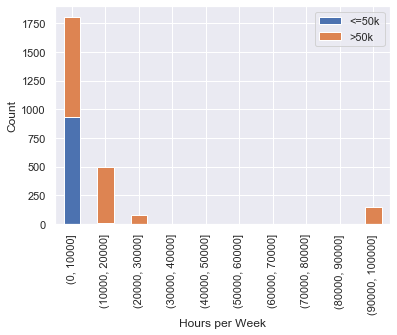

In [121]:
print("Mean value: ",np.round(np.mean(df['capitalgain']),2),"\nMaximum value", np.max(df['capitalgain']))
df.groupby(['fiftyk', pd.cut(df['capitalgain'], np.arange(0,110000,10000))]).size().unstack(0).plot.bar(stacked=True)
L=plt.legend()
L.get_texts()[0].set_text('<=50k')
L.get_texts()[1].set_text('>50k')
plt.xlabel('Hours per Week')
plt.ylabel('Count')
plt.show()

We will need to do a log transformation to make it usable.

In [122]:
dflog = df.copy()
dflog['capitalgain'] = dflog['capitalgain'].apply(
    lambda x: np.log(x + 1))

We can see that a majority have more than 50k so (surprise, surprise) having significant capital gains is correlated with making more than 50k.

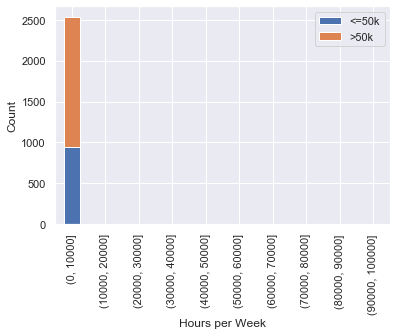

In [123]:
dflog.groupby(['fiftyk', pd.cut(dflog['capitalgain'], np.arange(0,110000,10000))]).size().unstack(0).plot.bar(stacked=True)
L=plt.legend()
L.get_texts()[0].set_text('<=50k')
L.get_texts()[1].set_text('>50k')
plt.xlabel('Hours per Week')
plt.ylabel('Count')
plt.show()

Based on these charts I think all of these will be worthwile candidates as predictive variables.

### Scaling the Data

First we will drop all of the columns we are not using.

In [124]:
dflog = dflog.drop(['capitalloss','nativecountry','fnlwgt','education','occupation','workclass','relationship','race'],axis=1)

Then we scale the numeric variables

In [125]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ['age', 'educationnum', 'capitalgain', 'hoursperweek']

dftrans = dflog.copy()
dftrans[features] = scaler.fit_transform(
    dflog[features])

## IV. Building a Model

We will try and use three different classification methods for modeling the data: K-nearest neighbors, Decision Tree, and Logistic Regression

### K-nearest neighbors

In [104]:
neigh = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
y,X = patsy.dmatrices('C(fiftyk,[[0],[1]]) ~ age + educationnum + C(maritalstatus) + C(sex) + hoursperweek + capitalgain',data=dftrans)
X_train, X_test, y_train, y_test = \
        X[::2],X[1::2], y[::2], y[1::2]
neigh.fit(X, y.ravel())

%time knn_hat = neigh.predict(X)
knn_cm = sklearn.metrics.confusion_matrix(y.ravel(), knn_hat)
print('Success Rate:', knn_cm[1,1] / (knn_cm[1,0] + knn_cm[1,1]))

Wall time: 26.9 s
Success =  0.7539957378795951


After trying several different values for k, I found k=1 to be the best by a large margin. 0.75 is not a terrible score, but the wall time is rather long. This of course is one of the disadvantages to using KNN with a larger dataset.

### Tree Classification

In [100]:
fiftyk = dftrans['fiftyk']
dftree = dftrans.drop(['fiftyk'],axis=1)
X_train, X_test, y_train, y_test = \
        dftree[::2],dftree[1::2], fiftyk[::2], fiftyk[1::2]

dtc = tree.DecisionTreeClassifier()
treemod = dtc.fit(X_train, y_train.ravel())
pred = dtc.predict(X_test)
print('Score is', metrics.accuracy_score(pred,y_test))

Score is 0.8085670711491281


0.80 is a marked improvement over the KNN method, and it processes in a fraction of the time.

### Logistic Regression

In [126]:
y,X = patsy.dmatrices('C(fiftyk,[[0],[1]]) ~ age + educationnum + C(maritalstatus) + sex + hoursperweek + capitalgain',data=dflog)
X_train, X_test, y_train, y_test = \
        X[::2], X[1::2], y[::2], y[1::2]
lrtest = sklearn.linear_model.LogisticRegression(solver="liblinear")
model = lrtest.fit(X_test,y_test.ravel())
print('Score is', model.score(X_test,y_test.ravel()))

Score is 0.8264703932099994


So among the three methods logistic performs the best by a small margin. I tried playing around with the formula but 0.826 was the highest score I could attain. I did find that some of the variables could be dropped without affecting the score too significantly, so it may be worthwhile to drop some variables in the interest of simplifying the model.